In [1]:
import sys
import os
from pathlib import Path
project_dir = Path(os.path.abspath('')).parent
sys.path.insert(0, project_dir.as_posix())

from tqdm import trange, tqdm
import numpy as np
import torch
from matplotlib import  pyplot as plt
from cs336_basics.nn_336 import TransformerLM
from cs336_basics.train import AdamW, cross_entropy, save_checkpoint, load_checkpoint, load_data, get_lr_cosine_schedule, gradient_clipping

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
%matplotlib inline

In [2]:
tokens = np.load(
    project_dir.joinpath("data", "TinyStoriesV2-GPT4-train-encoded.npy"), mmap_mode="r"
)

In [3]:
def train(
    model: TransformerLM,
    optimizer: AdamW,
    epochs,
    batch_size,
    T_w,
    T_c,
    checkpoint_dir=None,
    save_every=50,
):
    losses = optimizer.state["losses"]
    if checkpoint_dir is not None:
        checkpoint_dir = Path(checkpoint_dir)
        checkpoint_dir.mkdir(parents=True, exist_ok=True)
    for _ in trange(epochs):
        epoch = optimizer.state["epoch"] + 1
        # optimizer.param_groups[0]["lr"] = get_lr_cosine_schedule(
        #     epoch,
        #     (optimizer.state["init_lr"] / 10, optimizer.state["init_lr"]),
        #     T_w=T_w,
        #     T_c=T_c,
        # )
        x, target = load_data(tokens, batch_size, model.max_seq_len, device=device)
        pred = model(x)
        loss = cross_entropy(pred.view(-1, pred.shape[-1]), target.view(-1))

        optimizer.zero_grad()
        loss.backward()
        # gradient_clipping(model.parameters())
        optimizer.step()

        del x
        del target

        losses.append(loss.item())
        if epoch % save_every == 0:
            if checkpoint_dir is not None:
                save_checkpoint(
                    model,
                    optimizer,
                    epoch,
                    (checkpoint_dir / f"checkpoint_epoch_{epoch}.pt").as_posix(),
                )
            tqdm.write(f"----\nEpoch [{epoch}/{epochs}], Loss: {losses[-1]:.4f}\n")
            fig = plt.figure(figsize=(5, 1.5))
            ax = fig.add_axes(111)
            ax.plot(np.arange(epoch), losses)
            ax.set_xlabel('epoch')
            ax.set_ylabel('loss')
            plt.show()

In [4]:
model = TransformerLM(
    vocab_size=10000,
    num_layers=4,
    num_heads=16,
    d_model=512,
    d_ff=1344,
    max_seq_len=256,
    Theta=10000,
    device=device,
)
optimizer = AdamW(
    model.parameters(), lr=1e-5, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-2
)
load_checkpoint(project_dir / "checkpoints_beta2_0_999" / "checkpoint_epoch_5000.pt", model, optimizer)
optimizer.param_groups[0]['lr'] = 1e-5
optimizer.state['init_lr'] = 1e-5

 20%|█▉        | 99/500 [01:37<06:37,  1.01it/s]

----
Epoch [5100/500], Loss: 1.6168



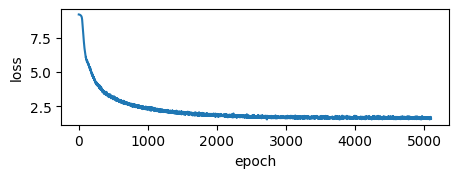

 40%|███▉      | 199/500 [03:18<05:05,  1.02s/it]

----
Epoch [5200/500], Loss: 1.6608



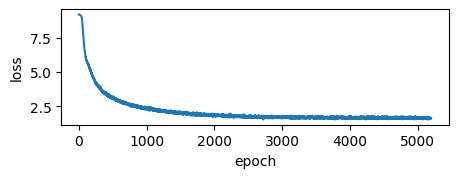

 60%|█████▉    | 299/500 [05:00<03:25,  1.02s/it]

----
Epoch [5300/500], Loss: 1.6156



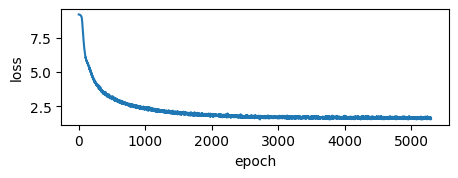

 80%|███████▉  | 399/500 [06:42<01:43,  1.02s/it]

----
Epoch [5400/500], Loss: 1.6557



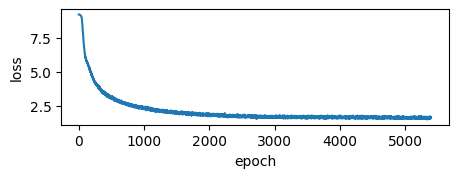

100%|█████████▉| 499/500 [08:25<00:01,  1.02s/it]

----
Epoch [5500/500], Loss: 1.6063



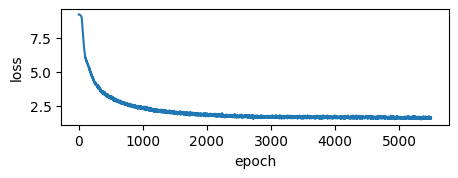

100%|██████████| 500/500 [08:25<00:00,  1.01s/it]


In [ ]:
train(
    model,
    optimizer,
    epochs=500,
    batch_size=64,
    checkpoint_dir=project_dir / "checkpoints_beta2_0_999_2",
    T_w=1,
    T_c=1,
    save_every=100,
)

 20%|█▉        | 99/500 [01:38<06:39,  1.00it/s]

----
Epoch [5600/500], Loss: 1.6780



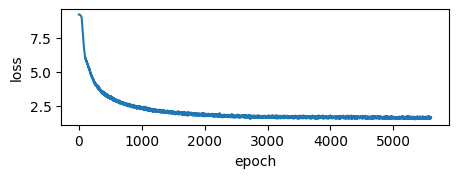

 40%|███▉      | 199/500 [03:18<05:05,  1.01s/it]

----
Epoch [5700/500], Loss: 1.6237



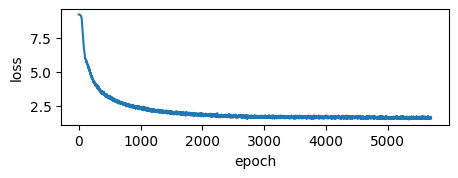

 60%|█████▉    | 299/500 [05:00<03:24,  1.02s/it]

----
Epoch [5800/500], Loss: 1.6609



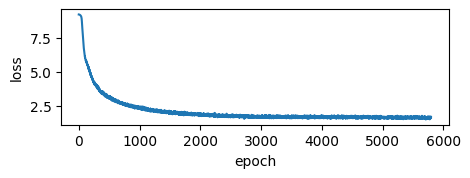

 80%|███████▉  | 399/500 [06:43<01:43,  1.02s/it]

----
Epoch [5900/500], Loss: 1.6810



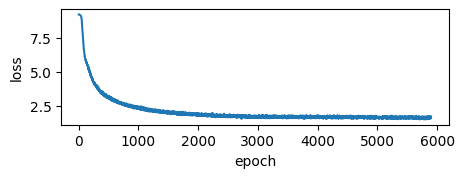

100%|█████████▉| 499/500 [08:26<00:01,  1.02s/it]

----
Epoch [6000/500], Loss: 1.6277



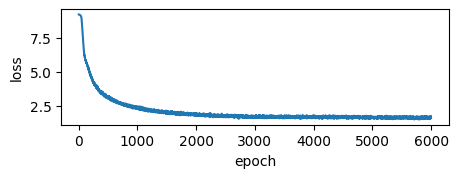

100%|██████████| 500/500 [08:26<00:00,  1.01s/it]


In [27]:
train(
    model,
    optimizer,
    epochs=500,
    batch_size=64,
    T_w=1,
    T_c=1,
    checkpoint_dir=project_dir / "checkpoints_beta2_0_999_2",
    save_every=100,
)

In [ ]:
model = TransformerLM(
    vocab_size=10000,
    num_layers=4,
    num_heads=16,
    d_model=512,
    d_ff=1344,
    max_seq_len=256,
    Theta=10000,
    device=device,
)
optimizer = AdamW(
    model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-2
)
load_checkpoint(project_dir / "checkpoints_beta2_0_999_2" / "checkpoint_epoch_5100.pt", model, optimizer)
optimizer.param_groups[0]['lr'] = 1e-3
optimizer.state['init_lr'] = 1e-3

 20%|█▉        | 99/500 [01:41<06:46,  1.01s/it]

----
Epoch [5200/500], Loss: 1.7248



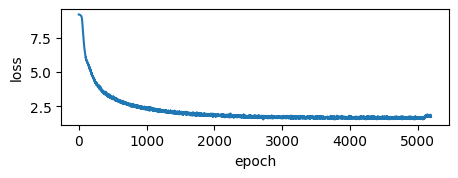

 40%|███▉      | 199/500 [03:23<05:07,  1.02s/it]

----
Epoch [5300/500], Loss: 1.8332



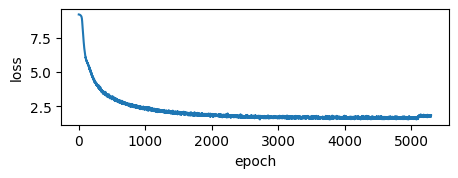

 56%|█████▌    | 281/500 [04:46<03:43,  1.02s/it]


KeyboardInterrupt: 

In [37]:
train(
    model,
    optimizer,
    epochs=500,
    batch_size=64,
    T_w=1,
    T_c=1,
    checkpoint_dir=project_dir / "checkpoints_beta2_0_999_2",
    save_every=100,
)

In [5]:
model = TransformerLM(
    vocab_size=10000,
    num_layers=4,
    num_heads=16,
    d_model=512,
    d_ff=1344,
    max_seq_len=256,
    Theta=10000,
    device=device,
)
optimizer = AdamW(
    model.parameters(), lr=1e-5, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-2
)
load_checkpoint(project_dir / "checkpoints_beta2_0_999_2" / "checkpoint_epoch_5100.pt", model, optimizer)
optimizer.param_groups[0]['lr'] = 1e-5
optimizer.state['init_lr'] = 1e-5

 20%|█▉        | 99/500 [01:13<04:22,  1.53it/s]

----
Epoch [5200/500], Loss: 1.6769



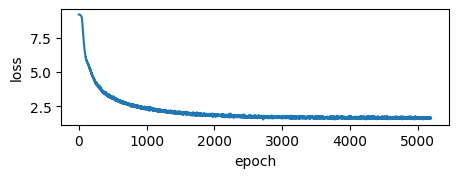

 40%|███▉      | 199/500 [02:21<03:17,  1.53it/s]

----
Epoch [5300/500], Loss: 1.6446



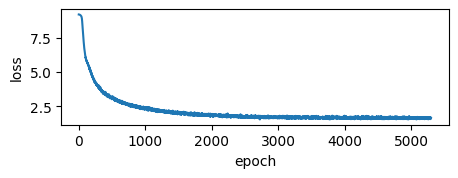

 60%|█████▉    | 299/500 [03:27<02:11,  1.53it/s]

----
Epoch [5400/500], Loss: 1.6300



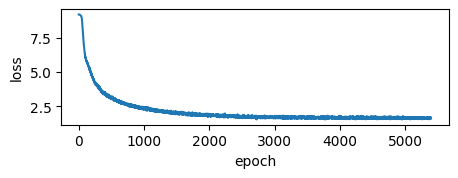

 80%|███████▉  | 399/500 [04:34<01:06,  1.52it/s]

----
Epoch [5500/500], Loss: 1.6287



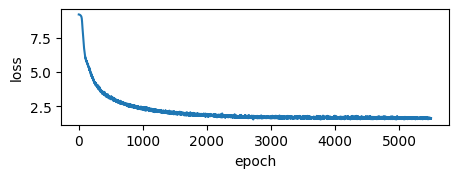

100%|█████████▉| 499/500 [05:40<00:00,  1.52it/s]

----
Epoch [5600/500], Loss: 1.6837



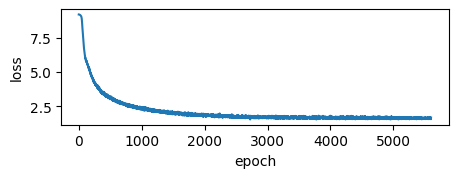

100%|██████████| 500/500 [05:40<00:00,  1.47it/s]


In [6]:
train(
    model,
    optimizer,
    epochs=500,
    batch_size=128,
    T_w=1,
    T_c=1,
    checkpoint_dir=project_dir / "checkpoints_beta2_0_999_2",
    save_every=100,
)

In [8]:
model = TransformerLM(
    vocab_size=10000,
    num_layers=4,
    num_heads=16,
    d_model=512,
    d_ff=1344,
    max_seq_len=256,
    Theta=10000,
    device=device,
)
optimizer = AdamW(
    model.parameters(), lr=1e-5, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-2
)
load_checkpoint(project_dir / "checkpoints_beta2_0_999_2" / "checkpoint_epoch_5100.pt", model, optimizer)
optimizer.param_groups[0]['lr'] = 1e-5
optimizer.state['init_lr'] = 1e-5

 80%|███████▉  | 399/500 [01:04<00:16,  6.25it/s]

----
Epoch [5500/500], Loss: 1.5633



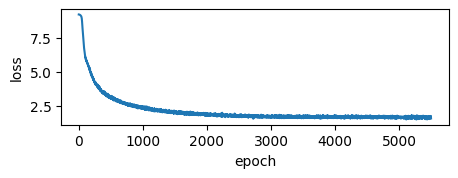

100%|██████████| 500/500 [01:20<00:00,  6.22it/s]


In [9]:
train(
    model,
    optimizer,
    epochs=500,
    batch_size=33,
    T_w=1,
    T_c=1,
    checkpoint_dir=project_dir / "checkpoints_beta2_0_999_2",
    save_every=500,
)

 10%|▉         | 199/2000 [00:32<04:48,  6.25it/s]

----
Epoch [5800/2000], Loss: 1.6621



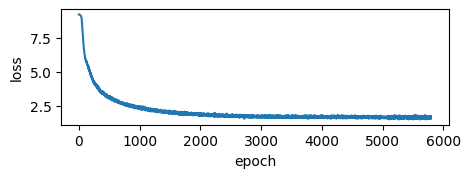

 20%|█▉        | 399/2000 [01:04<04:16,  6.24it/s]

----
Epoch [6000/2000], Loss: 1.6931



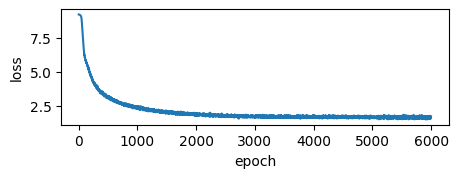

 30%|██▉       | 599/2000 [01:36<03:44,  6.24it/s]

----
Epoch [6200/2000], Loss: 1.6198



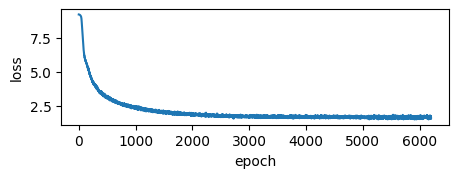

 40%|███▉      | 799/2000 [02:09<03:12,  6.24it/s]

----
Epoch [6400/2000], Loss: 1.6640



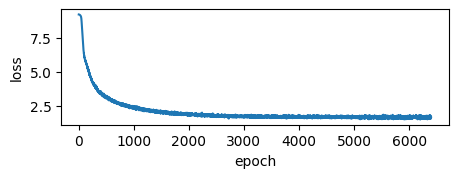

 50%|████▉     | 999/2000 [02:41<02:40,  6.24it/s]

----
Epoch [6600/2000], Loss: 1.7151



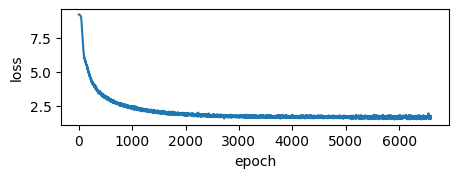

 60%|█████▉    | 1199/2000 [03:14<02:08,  6.24it/s]

----
Epoch [6800/2000], Loss: 1.6365



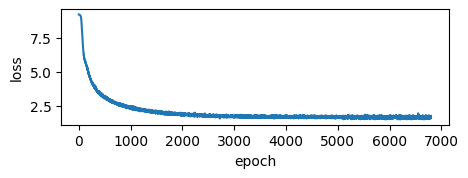

 70%|██████▉   | 1399/2000 [03:46<01:36,  6.24it/s]

----
Epoch [7000/2000], Loss: 1.6685



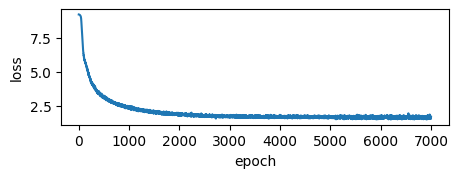

 80%|███████▉  | 1599/2000 [04:19<01:04,  6.23it/s]

----
Epoch [7200/2000], Loss: 1.5895



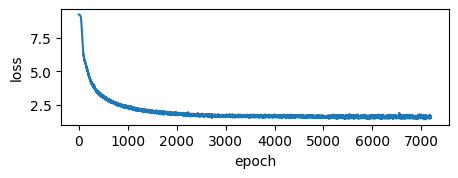

 90%|████████▉ | 1799/2000 [04:51<00:32,  6.23it/s]

----
Epoch [7400/2000], Loss: 1.7040



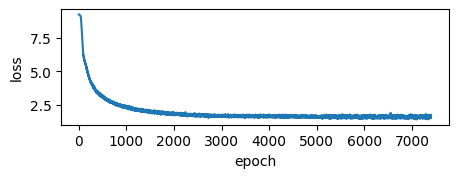

100%|█████████▉| 1999/2000 [05:23<00:00,  6.22it/s]

----
Epoch [7600/2000], Loss: 1.5532



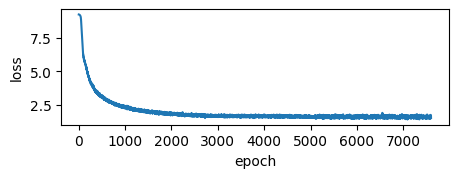

100%|██████████| 2000/2000 [05:24<00:00,  6.17it/s]


In [10]:
train(
    model,
    optimizer,
    epochs=2000,
    batch_size=33,
    T_w=1,
    T_c=1,
    checkpoint_dir=project_dir / "checkpoints_beta2_0_999_2",
    save_every=200,
)

In [12]:
model = TransformerLM(
    vocab_size=10000,
    num_layers=4,
    num_heads=16,
    d_model=512,
    d_ff=1344,
    max_seq_len=256,
    Theta=10000,
    device=device,
)
optimizer = AdamW(
    model.parameters(), lr=5e-6, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-2
)
load_checkpoint(project_dir / "checkpoints_beta2_0_999_2" / "checkpoint_epoch_7600.pt", model, optimizer)
optimizer.param_groups[0]['lr'] = 5e-6
optimizer.state['init_lr'] = 5e-6

In [ ]:
train(
    model,
    optimizer,
    epochs=500,
    batch_size=33,
    T_w=1,
    T_c=1,
    checkpoint_dir=project_dir / "checkpoints_beta2_0_999_2",
    save_every=1000,
)

100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


In [22]:
with torch.no_grad():
    eps = 1e-6
    norm_square = 0
    for p in model.parameters():
        if p.grad is None:
            continue
        param_norm = p.grad.data.norm(2)
        norm_square += param_norm**2
    print(norm_square)

tensor(0.1958, device='cuda:0')
